# Examen visión computacional
---

## Instrucciones
---

1. Revisa el dataset que se incluye en las celdas siguientes.
2. En base a este, crea un clasificador que pueda decir el tipo de coche y su color.
3. Llena las celdas de código como se va solicitando.
4. Al terminar, sube el notebook con todas las celdas ejecutadas a canvas.

## Imports

In [45]:
import numpy as np
import cv2
import os
import math

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import pandas as pd

import torchmetrics
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt

In [33]:
# Local settings


# importante cambiar path en caso de querer probar localmente
ABS_PATH_DATASET = "~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars/"

ABS_PATH_DATASET = os.path.expanduser(ABS_PATH_DATASET)

ABS_PATH_MANUAL_TESTING_DATASET = "~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/"
ABS_PATH_MANUAL_TESTING_DATASET = os.path.expanduser(ABS_PATH_MANUAL_TESTING_DATASET)

cuda_available = torch.cuda.is_available()
mps_available = getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available()

if cuda_available:
    device = torch.device("cuda")
    accelerator = "gpu"
    devices = 1
elif mps_available:
    device = torch.device("mps")
    accelerator = "mps"
    devices = 1
else:
    device = torch.device("cpu")
    accelerator = "cpu"
    devices = None

pin_memory = True if cuda_available else False

print(f"Using device={device} (cuda={cuda_available}, mps={mps_available}), accelerator={accelerator}, devices={devices}")

Using device=mps (cuda=False, mps=True), accelerator=mps, devices=1


## Descarga del dataset

In [4]:

!curl -sSL https://www.kaggle.com/api/v1/datasets/download/julichitai/multilabel-small-car-and-color-dataset -o ./cars_multilabel.zip
!unzip -q cars_multilabel.zip -d ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars
!rm cars_multilabel.zip


In [5]:
!ls $ABS_PATH_DATASET

matiz black matiz red   rio blue    tiggo black tiggo red
matiz blue  rio black   rio red     tiggo blue


In [6]:
!ls $ABS_PATH_DATASET/matiz\ black

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000013.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg
000020.jpg
000021.jpg
000022.jpg
000023.jpg
000024.jpg
000025.jpg
000026.jpg
000027.jpg
000028.jpg
000029.jpg
000030.jpg
000031.jpg
000032.jpg
000033.jpg
000034.jpg
000035.jpg
000036.jpg
000037.jpg
000038.jpg
000039.jpg
000040.jpg
000041.jpg
000042.jpg
000043.jpg
000044.jpg
000045.jpg
000046.jpg
000047.jpg
000048.jpg
000049.jpg
000050.jpg
000051.jpg
000052.jpg
000053.jpg
000054.jpg
000055.jpg
000056.jpg
000057.jpg
000058.jpg
000059.jpg
000060.jpg
000061.jpg
000062.jpg
000063.jpg
000064.jpg
000065.jpg
000066.jpg
000067.jpg
000068.jpg
000070.jpg
000071.jpg
000072.jpg
000073.jpg
000074.jpg
000076.jpg
000077.jpg
000081.jpg
000082.jpg
000083.jpg
000084.jpg
000085.jpg
000094.jpg
000099.jpg
000100.jpg
000101.jpg
000102.jpg
000105.jpg
000108.jpg
000112.jpg
000113.jpg
000125.jpg
000186.jpg

## Visualización de imágenes **(5 puntos)**
---

**TO DO**: Visualiza una imagen de cada clase.

Number of classes in dataset: 9


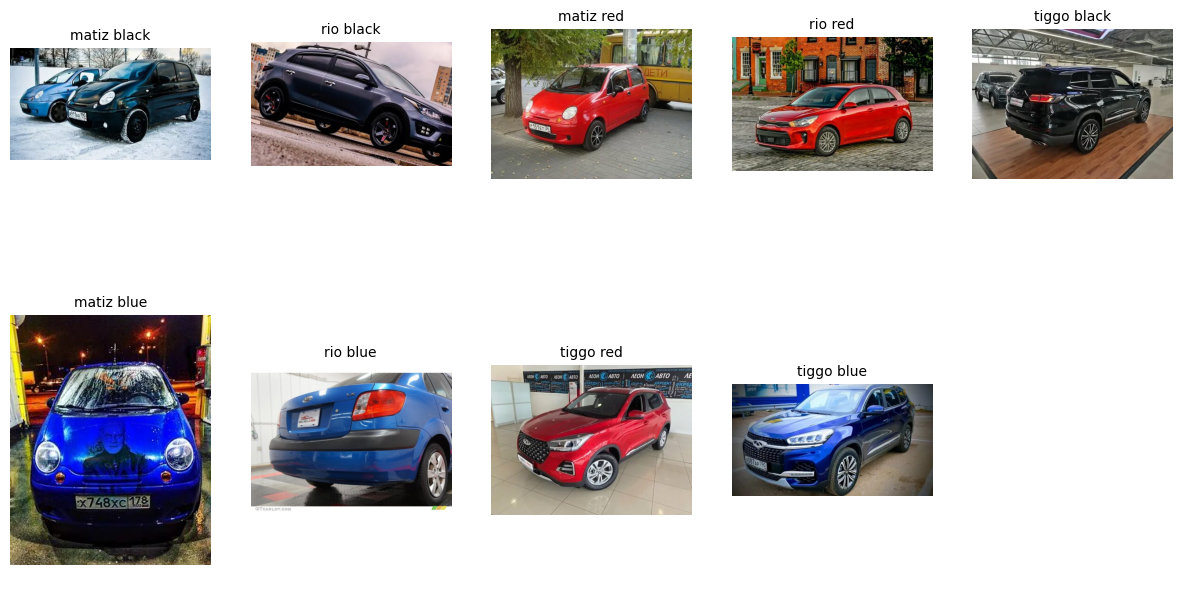

In [60]:

num_classes = len(os.listdir(ABS_PATH_DATASET))
print(f"Number of classes in dataset: {num_classes}")

cols = 5
rows = math.ceil(num_classes/cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten() if num_classes > 1 else [axes]

for i, class_name in enumerate(os.listdir(ABS_PATH_DATASET)):
    class_path = os.path.join(ABS_PATH_DATASET, class_name)
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(class_name, fontsize=10)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


se pude ver que hay algunos modelos de coches un poco viejos, pero al entrar a inspeccionar manualmente, también vpi que hay modelos recientes, así que se podría decir que en una clase van a caber dos o más tipos de modelos, veremos como maneja esto la red

In [8]:
def analyze_dataset(path):
    class_counts = {}
    total_images = 0

    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if not os.path.isdir(class_path):
            continue
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png','.jpg','.jpeg','.ppm'))])
        class_counts[class_name] = num_images
        total_images += num_images

    
    average_images_per_class = total_images / len(class_counts)
    for class_name, count in class_counts.items():
        print(f"Class '{class_name}': {count} images")

    
    print(f"\nTotal number of images: {total_images}")
    print(f"Average number of images per class: {average_images_per_class:.2f}")
    print(f"Class with least images: {min(class_counts, key=class_counts.get)} ({min(class_counts.values())} images)")
    print(f"Class with most images: {max(class_counts, key=class_counts.get)} ({max(class_counts.values())} images)")


def sample_image_dims(path):
    files = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            cls_files = [os.path.join(class_path, f) for f in os.listdir(class_path)]
            files.extend(cls_files)
    
    dims = []
    for img_path in files:
        img = cv2.imread(img_path)
        dims.append((img.shape[1], img.shape[0]))
    
    dims = np.array(dims)
    print(f"\nImage size statistics:")
    print(f"Width: min={dims[:,0].min()}, max={dims[:,0].max()}, mean={dims[:,0].mean():.1f}, std={dims[:,0].std():.1f}")
    print(f"Height: min={dims[:,1].min()}, max={dims[:,1].max()}, mean={dims[:,1].mean():.1f}, std={dims[:,1].std():.1f}")


analyze_dataset(ABS_PATH_DATASET)
sample_image_dims(ABS_PATH_DATASET)

Class 'matiz black': 235 images
Class 'rio black': 306 images
Class 'matiz red': 346 images
Class 'rio red': 431 images
Class 'tiggo black': 286 images
Class 'matiz blue': 334 images
Class 'rio blue': 262 images
Class 'tiggo red': 262 images
Class 'tiggo blue': 273 images

Total number of images: 2735
Average number of images per class: 303.89
Class with least images: matiz black (235 images)
Class with most images: rio red (431 images)

Image size statistics:
Width: min=138, max=5760, mean=686.3, std=442.8
Height: min=124, max=3840, mean=472.9, std=300.7

Image size statistics:
Width: min=138, max=5760, mean=686.3, std=442.8
Height: min=124, max=3840, mean=472.9, std=300.7


Se puede ver que las imágenes están bastante balanceadas en cuanto a cantidad en cada clase, mas en tamaño no mucho, varían mucho en tamaño

## Carga de imágenes en dataloaders **(15 puntos)**
---

**TO DO**: Construye los dataloaders necesarios, con las transformaciónes adecuadas, y muestra un batch. Connstruye las etiquetas de las imágenes para poder hacer clasificación multi-etiqueta.

In [16]:

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop((128, 128)),
    transforms.RandomHorizontalFlip(.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

añadí la random rotation ya que en este tipo de imágenes no importa mucho si están espejeadas, de hecho, enriquece al modelo porque es como si el coche estuviera tomado desde otro punto

In [17]:
import lightning as L

class CarDataModule(L.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, num_workers=4, train_transform=None, test_transform=None, pin_memory=False):
        super().__init__()
        self.data_dir = os.path.expanduser(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.pin_memory = pin_memory
        self.setup()

    def setup(self, stage=None):
        full_dataset = ImageFolder(self.data_dir, transform=self.train_transform)
        
        total_size = len(full_dataset)
        train_size = int(.7 * total_size)
        val_size = int(.15 * total_size)
        test_size = total_size - train_size - val_size
        
        self.train, self.val, self.test = random_split(
            full_dataset, 
            [train_size, val_size, test_size],
            generator=torch.Generator().manual_seed(42)
        )
        
        self.val.dataset.transform = self.test_transform
        self.test.dataset.transform = self.test_transform
        
        self.num_classes = len(full_dataset.classes)
        self.classes = full_dataset.classes

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            persistent_workers=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

Datamodule estándar como le habíamos estado haciendo, hice el split de train/val7test dentro del mismo

Batch shapes -> images: torch.Size([16, 3, 128, 128]) labels: torch.Size([16])
Classes: ['matiz black', 'matiz blue', 'matiz red', 'rio black', 'rio blue', 'rio red', 'tiggo black', 'tiggo blue', 'tiggo red']
Number of classes: 9


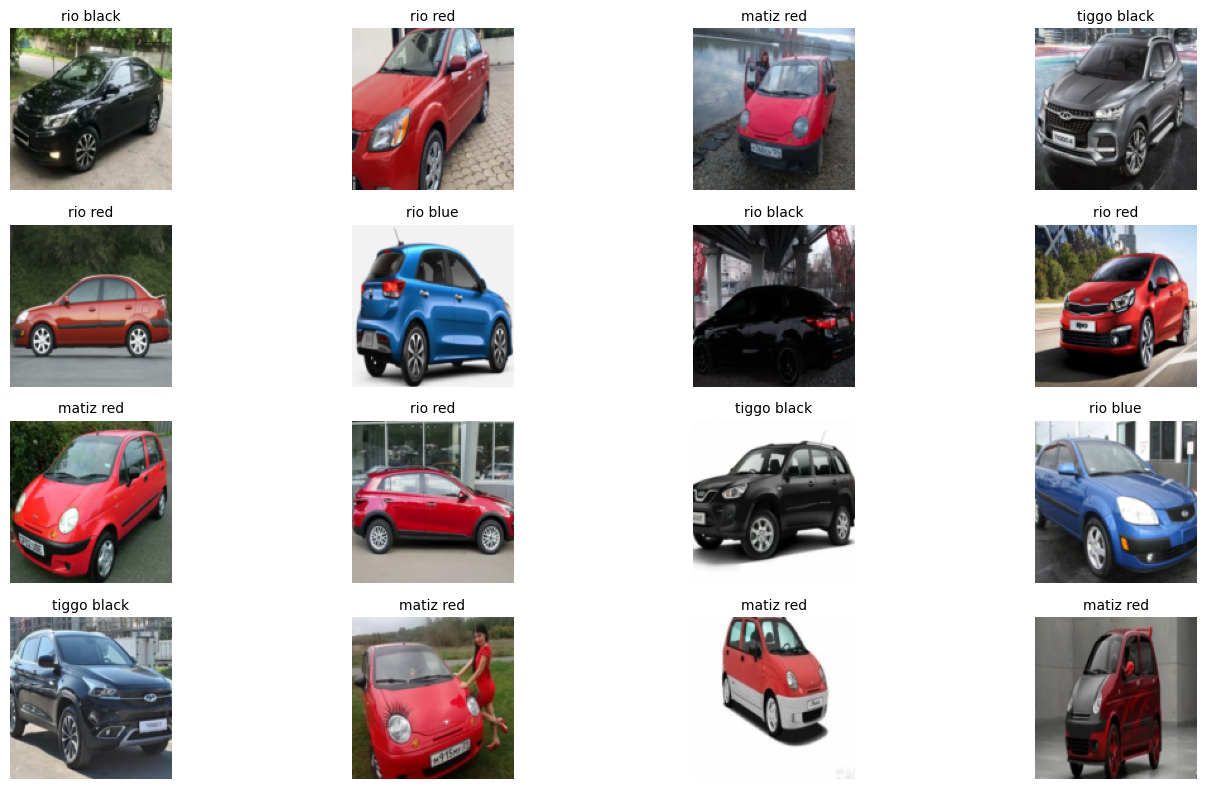

In [61]:
dm = CarDataModule(ABS_PATH_DATASET, batch_size=16, train_transform=train_transform, test_transform=test_transform, pin_memory=pin_memory)

loader = dm.train_dataloader()
images, labels = next(iter(loader))

print('Batch shapes -> images:', images.shape, 'labels:', labels.shape)
print(f'Classes: {dm.classes}')
print(f'Number of classes: {dm.num_classes}')

inv = lambda x: x * 0.5 + 0.5

n = images.size(0)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i in range(n):
    img = inv(images[i]).permute(1, 2, 0).cpu().numpy()
    axes[i].imshow(img)
    
    class_name = dm.classes[labels[i].item()]
    
    axes[i].set_title(class_name, fontsize=10)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Visualización de imágenes de training ya carhadas en el dataloader

## Definición del modelo **(15 puntos)**
---

**TO DO**: Crea un modelo con capas convolucionales para hacer la clasificación.

In [ ]:
resnet_model = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")

for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.layer4.requires_grad_(True)

resnet_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, dm.num_classes)
)
resnet_model.fc

Se utilizará el modelo de resnet18 ya que he tenido buena experiencia para clasificación multiclase de imágenes en las que no se necesita capturar gran detalle de ellas, por lo que las imágenes pueden ser redimensionadas a una escala no muy grande para lograr una buena velocidad de entrenamiento

In [23]:
class CarModelLightning(L.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = model
        
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        
        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        
        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, true_labels, predicted_labels = self._shared_step(batch)
            self.test_acc(predicted_labels, true_labels)
            self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

Wrapper del modelo con Lightning, en donde se definen los steps en métodos de la clase abstracta de Lightning

## Entrenamiento **(5 puntos)**
---

**TO DO**: Entrena el modelo, y muestra los resultados de validación y entrenamiento.

In [24]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

car_model_lightning = CarModelLightning(
    model=resnet_model,
    learning_rate=0.001,
    num_classes=dm.num_classes
)

print(f"device={device}, accelerator={accelerator}, devices={devices}")

trainer = L.Trainer(
    accelerator=accelerator, 
    devices=devices or 0,
    logger=CSVLogger(save_dir="logs/", name="car-classifier-resnet18"),
    max_epochs=20,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)],
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


device=mps, accelerator=mps, devices=1


Se crea el trainer al que se le pasa el modelo, se configura el logger, y el callback de earlystopping

In [25]:
trainer.fit(model=car_model_lightning, datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
8.4 M     Trainable params
2.8 M     Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 7: 100%|██████████| 119/119 [00:03<00:00, 36.78it/s, v_num=4, val_loss=0.445, val_acc=0.893, train_acc=0.960]



Se puede ver que el entrenamiento para en la época 7 por la política del earlystopper. 

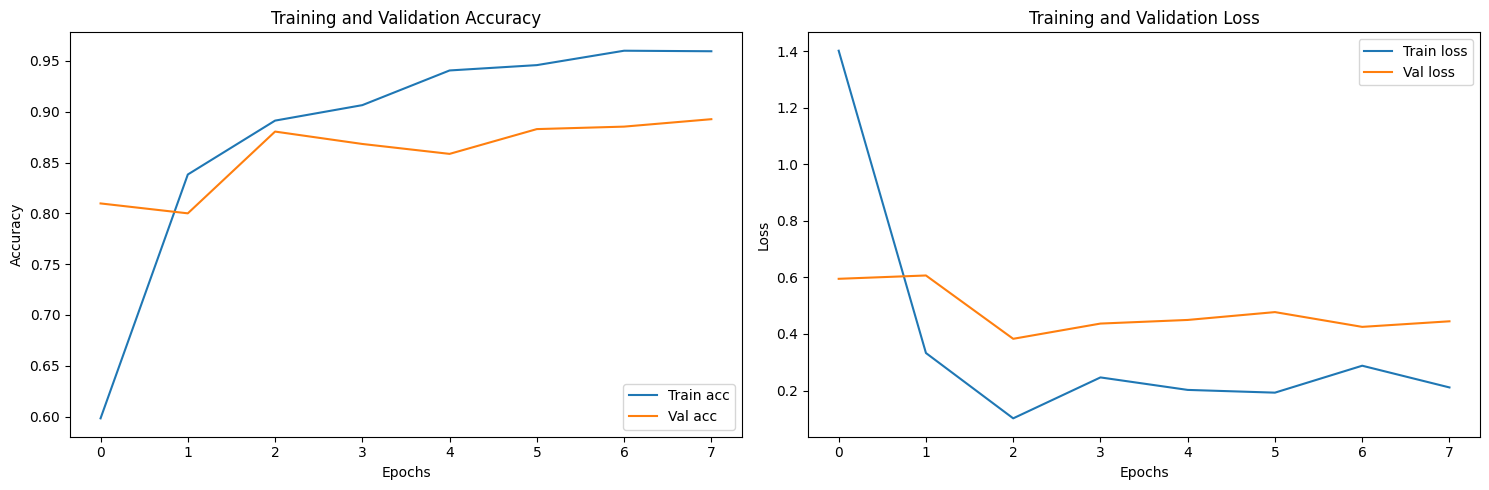

In [27]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
df_epochs = metrics.groupby('epoch').mean()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].plot(df_epochs['train_acc'], label="Train acc")
axes[0].plot(df_epochs['val_acc'], label="Val acc")
axes[0].set_title("Training and Validation Accuracy")
axes[0].legend(loc='lower right')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].plot(df_epochs['train_loss'], label="Train loss")
axes[1].plot(df_epochs['val_loss'], label="Val loss")
axes[1].set_title("Training and Validation Loss")
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Se llegó a una accuracy muy alta, alcanzando el 89% el validación y 96% en training, y también un loss muy bajo.

Considero que el modelo quedó ligeramente overfitteado, ya que hay una diferencia de 7% entre training y validation

## Pruebas **(5 puntos)**
---

**TO DO**: Prueba el desempeño de tu modelo con datos de prueba.

In [29]:
trainer.test(datamodule=dm)

Restoring states from the checkpoint path at logs/car-classifier-resnet18/version_4/checkpoints/epoch=7-step=952.ckpt
Loaded model weights from the checkpoint at logs/car-classifier-resnet18/version_4/checkpoints/epoch=7-step=952.ckpt
Loaded model weights from the checkpoint at logs/car-classifier-resnet18/version_4/checkpoints/epoch=7-step=952.ckpt


Testing DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 53.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8613138794898987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8613138794898987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.8613138794898987}]

En testing conseguimos una accuracy de 86%, resultado de que el modelo está ligeramente overfitteado, lo ideal sería que ésta sea igual a la de validación

## Predicción **(5 puntos)**
---

**TO DO**: Descarga una imagen, y haz una predicción sobre ella. Usa wget como en el siguiente ejemplo.

In [ ]:
!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/matiz_rojo.jpg https://i.pinimg.com/736x/83/90/e7/8390e7fb457d2b87f98483982ebe4a62.jpg

!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/kia_rio_rojo.jpg https://cdn.pixabay.com/photo/2018/04/09/22/07/car-3305699_1280.jpg

!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/kia_rio_azul.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/KIA_Rio_-_CIAS_2012_%286787393208%29.jpg/640px-KIA_Rio_-_CIAS_2012_%286787393208%29.jpg

!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/kia_rio_negro.jpeg https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Kia_YB_Rio_Hatch.jpeg/640px-Kia_YB_Rio_Hatch.jpeg

!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/tiggo_negro.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Chery_Tiggo_DR_Edition_IMG001.jpg/640px-Chery_Tiggo_DR_Edition_IMG001.jpg

!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/tiggo_rojo.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Chery_Tiggo_facelift_II_China_2012-05-12.jpg/640px-Chery_Tiggo_facelift_II_China_2012-05-12.jpg

!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/matiz_negro.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Matiz_017.jpg/640px-Matiz_017.jpg


!wget -O ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets/DL_Data_sets-main/cars-manual-testing/matiz_azul.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Daewoo_Matiz_%28front%29%2C_Denpasar.jpg/640px-Daewoo_Matiz_%28front%29%2C_Denpasar.jpg

Importante cambiar la ruta de destino de las descargas en caso de querer probar de forma local

dato curioso: me banearon de pinterest al estar copiando links de descargas, yo creo que vieron mi actividad sospechosa

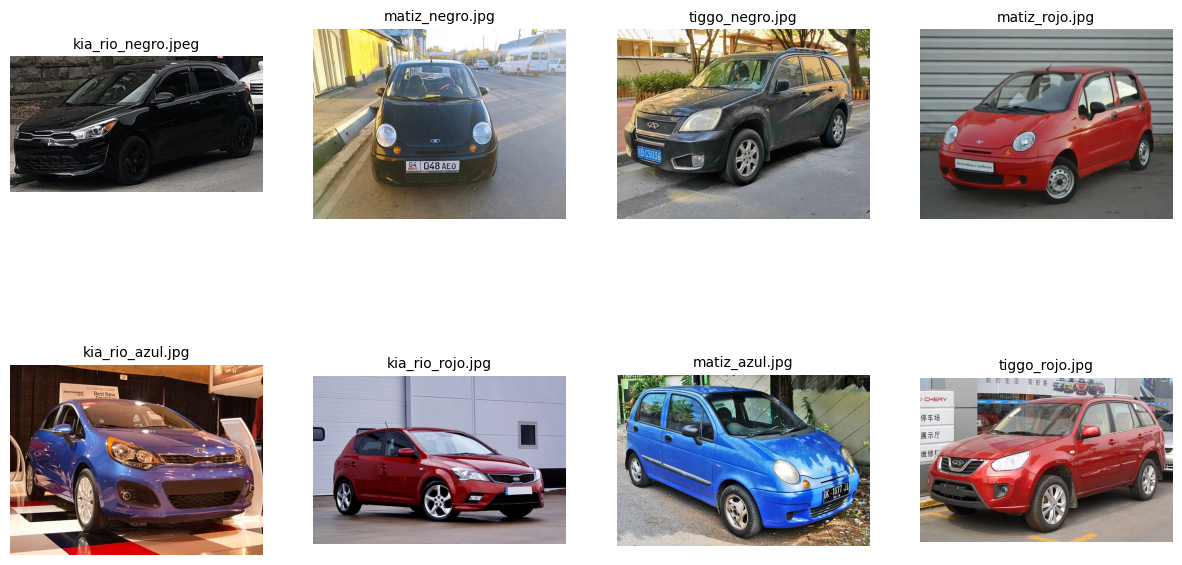

In [62]:

manual_test_images = os.listdir(ABS_PATH_MANUAL_TESTING_DATASET)


n_imgs = len(manual_test_images)
cols = 4
rows = math.ceil(n_imgs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten() if n_imgs > 1 else [axes]

for i, img_name in enumerate(manual_test_images):
    img_path = os.path.join(ABS_PATH_MANUAL_TESTING_DATASET, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(img)
    axes[i].set_title(img_name, fontsize=10)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

Imágenes descargadas de internet

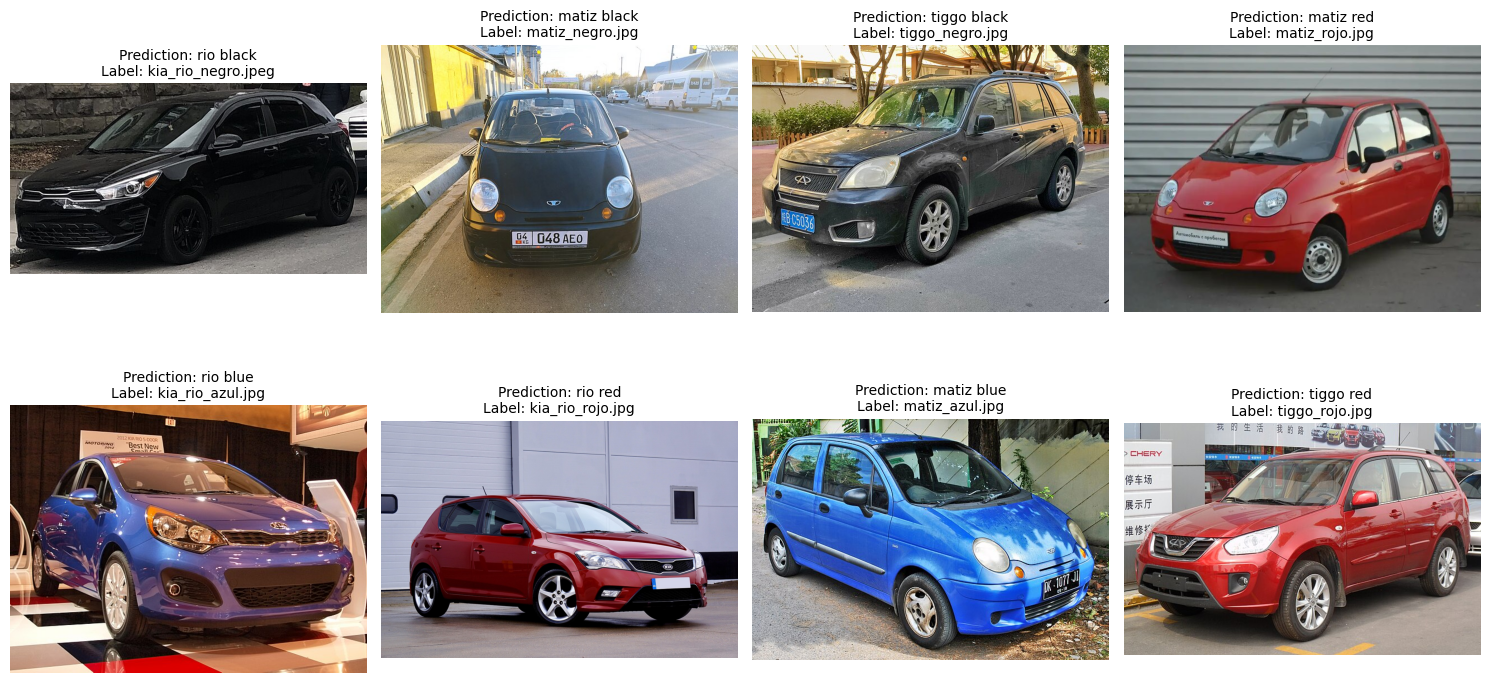

In [63]:
from PIL import Image

car_model_lightning.to(device).eval()

n_imgs = len(manual_test_images)
cols = 4
rows = math.ceil(n_imgs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten() if n_imgs > 1 else [axes]

for i, img_name in enumerate(manual_test_images):
    img_path = os.path.join(ABS_PATH_MANUAL_TESTING_DATASET, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    pil_img = Image.fromarray(img)
    img_tensor = test_transform(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = car_model_lightning(img_tensor)
        pred_idx = int(logits.argmax(dim=1).cpu().item())
        pred_class = dm.classes[pred_idx]

    axes[i].imshow(img)
    axes[i].set_title(f"Prediction: {pred_class}\nLabel: {img_name}", fontsize=10)
    axes[i].axis('off')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Probando con las imágenes descargadas de internet, en todos los casos en modelo predijo la clase correcta, ésto se lo atribuyo al dataset, que por ejemplo comparado con el de las señales alemanas, tiene una mejor calidad, distribución más pareja y sobre todo el encuadre de los coches varía mucho y no solo es de un tipo, lo que hace al modelo más versátil y capaz de clasificar fotos más realistas de coches, sin estar en un ambiente controlado